In [29]:
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from azure.storage.blob import BlobServiceClient

In [30]:
import src.paychex_ml as pml
pml.__file__

In [31]:
from src.paychex_ml.utils import load_credentials

In [32]:
credentials = load_credentials("blob_storage",
                               file="C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/credentials.yml")

In [33]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

In [34]:
# Download file
file = 'paychex_revenue.parquet'
stream_downloader = container_client.download_blob(file)
stream = BytesIO()
stream_downloader.readinto(stream)

46014

In [35]:
df = pd.read_parquet(stream, engine='pyarrow')

In [41]:
df['Calendar Date'] = pd.PeriodIndex(df['Calendar Date'], freq='M')
#df = df.set_index('Calendar Date')
df_month = df[df['Scenario']=='Actual']


In [42]:
df_month['Year'] = df_month['Fiscal Period'].str.slice(0,4)

<ipython-input-42-e85158d30ba2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['Year'] = df_month['Fiscal Period'].str.slice(0,4)


In [43]:
df_month

,Scenario,Version,Fiscal Period,Calendar Date,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,...,52 Full Service Unemployment Revenue,53 ESR Revenue,54 Cafeteria,55 Benetrac,56 Emerging Products,60 Total PEO,71 Workers Comp - Payment Services,72 Health Benefits,80 Interest on Funds Held for Clients,Year
1,Actual,Final Revised,FY1501,2014-06,99633512.0,7031234.09,7393351.97,7255027.55,4765775.19,3246967.02,...,1869396.0,47601.0,1714950.0,1922941.0,796066.0,12948698.0,5225672.0,4858397.0,3308153.0,FY15
2,Actual,Final Revised,FY1502,2014-07,121619696.0,7325377.82,13513741.18,9070820.80,6502729.54,3362473.02,...,2341533.0,67520.0,1698493.0,1916578.0,986957.0,14670280.0,5108935.0,5244319.0,3466374.0,FY15
3,Actual,Final Revised,FY1503,2014-08,99472483.0,7443620.46,7286966.62,7489159.50,4215268.17,3286111.93,...,1986835.0,79771.0,1829119.0,1944829.0,924688.0,14606683.0,5380160.0,5588578.0,3434418.0,FY15
4,Actual,Final Revised,FY1504,2014-09,94198230.0,7414842.11,7081861.96,7011292.24,4726806.24,3345328.53,...,1888067.0,105330.0,1710601.0,1933042.0,732445.0,14456324.0,6281391.0,4968759.0,3419918.0,FY15
5,Actual,Final Revised,FY1505,2014-10,124353873.0,7818212.35,13741077.44,9372927.59,6514037.07,3402641.78,...,2491011.0,143956.0,1702223.0,1956820.0,1051918.0,14544807.0,6107474.0,5752070.0,3472038.0,FY15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Actual,Final Revised,FY2108,2021-01,94834624.0,80988881.77,22548298.89,13265382.71,8645189.69,7062932.96,...,3071646.0,3955285.0,1771610.0,1390061.0,4341242.0,71734133.0,8756918.0,5399816.0,5034426.0,FY21
87,Actual,Final Revised,FY2109,2021-02,96978102.0,28599.77,6430193.76,13666646.86,6625228.73,6757198.28,...,3103960.0,11179899.0,1685096.0,1354163.0,3735643.0,65858228.0,9241920.0,5392816.0,4984652.0,FY21
88,Actual,Final Revised,FY2110,2021-03,110554131.0,-43477.46,7657980.44,16053700.85,6834861.06,7127288.42,...,3648120.0,5180500.0,1667440.0,1404115.0,4687473.0,70139851.0,10415876.0,7384007.0,5028117.0,FY21
89,Actual,Final Revised,FY2111,2021-04,105999185.0,44625.45,11701117.00,14728764.11,6416112.24,7072846.33,...,3297549.0,4329239.0,1683761.0,1349890.0,5767058.0,66380942.0,10902160.0,6571571.0,4669275.0,FY21


In [51]:
(df_month.groupby('Year').sum()/1000000).loc['FY21',:]

11 Payroll Blended Products              1263.873337
12 W2 Revenue                              82.427798
13 Delivery Revenue                       115.292900
14 ASO Allocation                         169.023967
15 Other Processing Revenue                68.979828
16 SurePayroll                             84.348711
17 Total International                     49.603871
20 Total 401k                             275.511726
31 HR Solutions (excl PEO)                486.187481
32 ASO Revenue - Oasis                      4.457039
41 HR Online                               49.617735
42 Time Attendance                        131.872768
51 Total Paychex Advance                   57.955642
52 Full Service Unemployment Revenue       39.606002
53 ESR Revenue                             48.297063
54 Cafeteria                               20.265764
55 Benetrac                                16.661907
56 Emerging Products                       47.747443
60 Total PEO                              789.

In [ ]:
df_month = df_month.select_dtypes(include=np.number)

In [10]:
df_month

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),32 ASO Revenue - Oasis,...,51 Total Paychex Advance,52 Full Service Unemployment Revenue,53 ESR Revenue,54 Cafeteria,55 Benetrac,56 Emerging Products,60 Total PEO,71 Workers Comp - Payment Services,72 Health Benefits,80 Interest on Funds Held for Clients
Calendar Date,,,,,,,,,,,,,,,,,,,,,
2014-06,99633512.0,7031234.09,7393351.97,7255027.55,4765775.19,3246967.02,808003.64,14883414.0,21143605.0,0.00,...,0.0,1869396.0,47601.0,1714950.0,1922941.0,796066.0,12948698.0,5225672.0,4858397.0,3308153.0
2014-07,121619696.0,7325377.82,13513741.18,9070820.80,6502729.54,3362473.02,855305.18,15071771.0,25838048.0,0.00,...,0.0,2341533.0,67520.0,1698493.0,1916578.0,986957.0,14670280.0,5108935.0,5244319.0,3466374.0
2014-08,99472483.0,7443620.46,7286966.62,7489159.50,4215268.17,3286111.93,801651.38,14783933.0,21762760.0,0.00,...,0.0,1986835.0,79771.0,1829119.0,1944829.0,924688.0,14606683.0,5380160.0,5588578.0,3434418.0
2014-09,94198230.0,7414842.11,7081861.96,7011292.24,4726806.24,3345328.53,834334.16,17075301.0,20288451.0,0.00,...,0.0,1888067.0,105330.0,1710601.0,1933042.0,732445.0,14456324.0,6281391.0,4968759.0,3419918.0
2014-10,124353873.0,7818212.35,13741077.44,9372927.59,6514037.07,3402641.78,869205.85,18252956.0,26755143.0,0.00,...,0.0,2491011.0,143956.0,1702223.0,1956820.0,1051918.0,14544807.0,6107474.0,5752070.0,3472038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01,94834624.0,80988881.77,22548298.89,13265382.71,8645189.69,7062932.96,4373773.19,23143326.0,38395293.0,274401.85,...,5542882.0,3071646.0,3955285.0,1771610.0,1390061.0,4341242.0,71734133.0,8756918.0,5399816.0,5034426.0
2021-02,96978102.0,28599.77,6430193.76,13666646.86,6625228.73,6757198.28,4321140.10,23583891.0,39462133.0,292114.39,...,5572132.0,3103960.0,11179899.0,1685096.0,1354163.0,3735643.0,65858228.0,9241920.0,5392816.0,4984652.0
2021-03,110554131.0,-43477.46,7657980.44,16053700.85,6834861.06,7127288.42,4330584.30,24032102.0,45766968.0,254020.04,...,6534834.0,3648120.0,5180500.0,1667440.0,1404115.0,4687473.0,70139851.0,10415876.0,7384007.0,5028117.0


In [13]:
df_month.resample('Y')['2021'.sum()/1000000

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),32 ASO Revenue - Oasis,...,51 Total Paychex Advance,52 Full Service Unemployment Revenue,53 ESR Revenue,54 Cafeteria,55 Benetrac,56 Emerging Products,60 Total PEO,71 Workers Comp - Payment Services,72 Health Benefits,80 Interest on Funds Held for Clients
Calendar Date,,,,,,,,,,,,,,,,,,,,,
2014,737.428125,52.693338,63.836021,55.046597,36.423927,23.492733,5.780052,115.599428,158.943352,0.000000,...,0.000000,14.632019,0.858578,12.180632,13.684252,6.310446,99.773574,39.007853,37.075734,24.121068
2015,1298.613489,93.593798,119.981656,102.871770,68.040582,44.321295,8.979380,195.885178,299.015634,0.000000,...,0.000000,28.668887,18.537087,20.713126,24.294082,12.197437,216.680787,69.784067,69.368606,43.845111
2016,1335.478785,40.203457,122.281340,113.286032,71.661903,50.509859,9.912922,198.254828,332.497428,0.000000,...,43.212226,32.207550,39.785961,20.706727,19.904694,14.178895,252.302113,75.894340,74.055770,47.973685
2017,1322.841738,93.712437,123.399251,118.558721,71.155219,59.318948,11.158371,217.891596,351.252019,0.000000,...,48.603195,33.726132,45.291374,21.334534,20.838701,15.951703,308.638873,82.641675,90.684305,56.979107
2018,1321.713907,97.793304,122.857733,133.743102,70.998695,63.527947,33.012195,238.451000,391.704221,0.002442,...,49.831955,35.529565,45.737804,21.133937,18.988027,18.495847,444.022913,90.838891,93.902514,73.044038
2019,1333.110629,93.606582,122.103483,151.859886,74.567814,71.998797,43.524187,253.132976,440.011888,8.126486,...,54.661853,37.937200,46.318042,21.016444,18.495660,23.018538,833.548566,99.038369,88.312594,84.877249
2020,1250.775892,90.319811,113.258838,158.040563,67.655937,80.253149,46.131017,266.747413,456.132428,6.428332,...,50.124070,38.287514,47.240780,20.732848,17.356750,37.455996,784.951344,101.879337,80.111996,73.709565
2021,509.695238,81.132147,55.064140,72.387118,33.715859,34.835204,21.818085,118.235343,208.316875,1.371014,...,29.685382,16.380416,26.225368,8.432689,6.870517,23.373733,345.050943,48.967397,30.701277,24.495616


# Monthly Actuals

In [39]:
df_month.sum()/1000000#.to_csv('sum.csv')

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [14]:
df_month.describe()

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services,80 Interest on Funds Held for Clients
count,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01,8.400000e+01
mean,1.084483e+08,7.958609e+06,1.003312e+07,1.078326e+07,6.234125e+06,5.098309e+06,2.146622e+06,1.909759e+07,3.140326e+07,1.297825e+07,1.492398e+07,3.910678e+07,1.395553e+07,5.107684e+06
std,9.354400e+06,2.108662e+07,3.986742e+06,2.195401e+06,1.178364e+06,1.554469e+06,1.438746e+06,2.662763e+06,6.162351e+06,2.019918e+06,4.726722e+06,2.225136e+07,2.243022e+06,1.613649e+06
min,9.094933e+07,-2.419720e+05,6.185802e+06,7.011292e+06,3.790476e+06,3.221739e+06,6.728264e+05,1.478393e+07,2.028845e+07,8.581821e+06,6.350954e+06,1.294870e+07,1.008407e+07,3.308153e+06
25%,1.002485e+08,1.814661e+05,7.443607e+06,9.259447e+06,5.411902e+06,4.032447e+06,8.211894e+05,1.685675e+07,2.703527e+07,1.159864e+07,1.352016e+07,1.980987e+07,1.227636e+07,3.840497e+06
50%,1.070092e+08,3.135933e+05,8.252243e+06,1.035877e+07,6.132526e+06,4.729663e+06,1.034863e+06,1.894864e+07,3.014123e+07,1.330167e+07,1.529533e+07,3.146800e+07,1.411706e+07,4.792190e+06
75%,1.155139e+08,7.512116e+06,1.198190e+07,1.235705e+07,6.765924e+06,5.801675e+06,3.577341e+06,2.111923e+07,3.589550e+07,1.441724e+07,1.766897e+07,6.466603e+07,1.554356e+07,6.033108e+06
max,1.286676e+08,9.538279e+07,2.254830e+07,1.605370e+07,1.006668e+07,1.208089e+07,4.400806e+06,2.463041e+07,4.576697e+07,1.724580e+07,2.757900e+07,8.755024e+07,2.207968e+07,1.344751e+07


## Time series plots

11 Payroll Blended Products


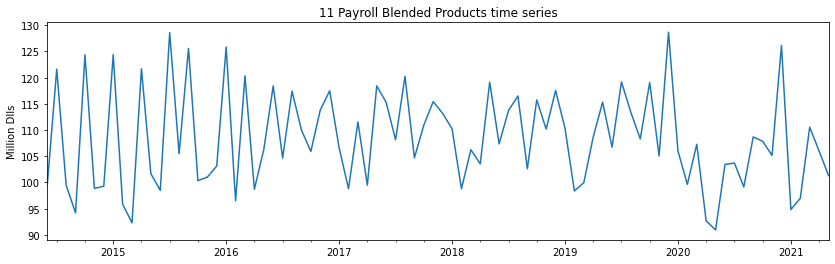

12 W2 Revenue


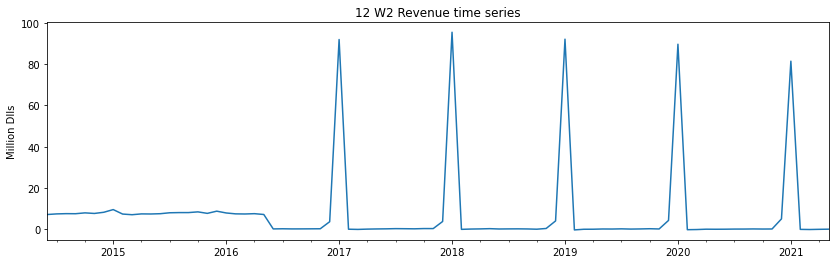

13 Delivery Revenue


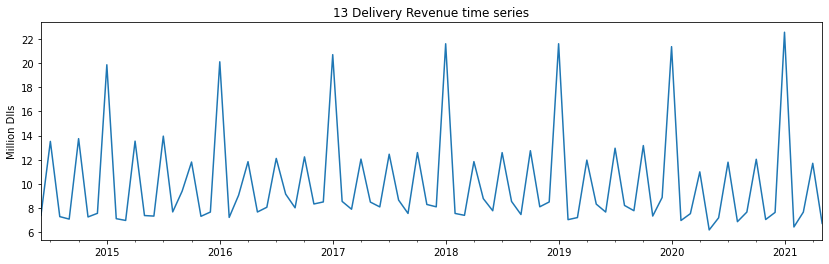

14 ASO Allocation


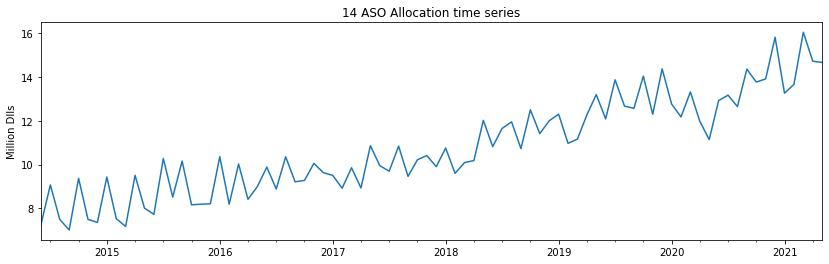

15 Other Processing Revenue


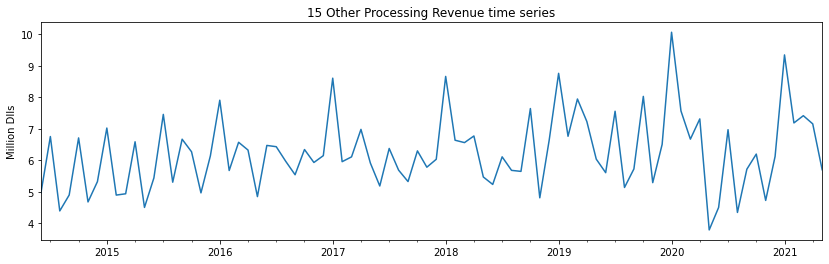

16 SurePayroll


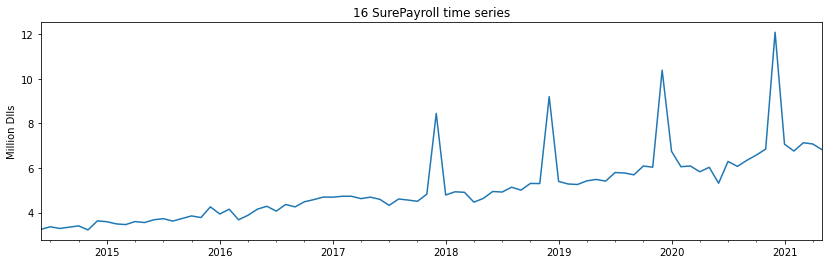

17 Total International


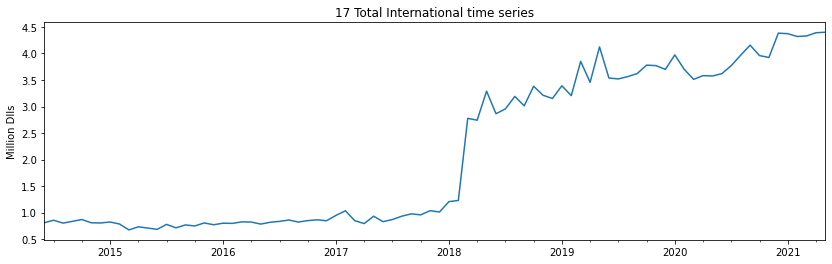

20 Total 401k


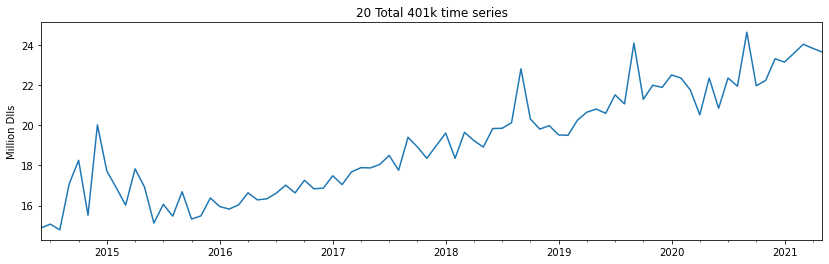

31 HR Solutions (excl PEO)


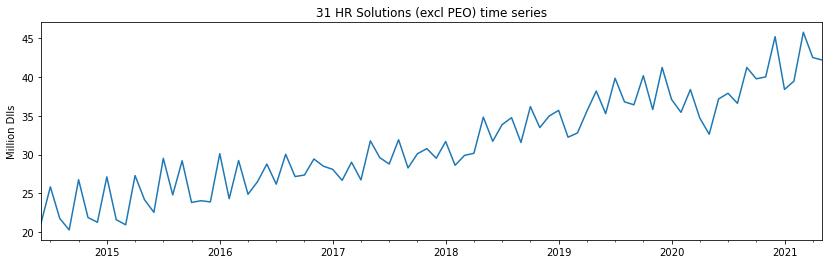

40 Total Online Services


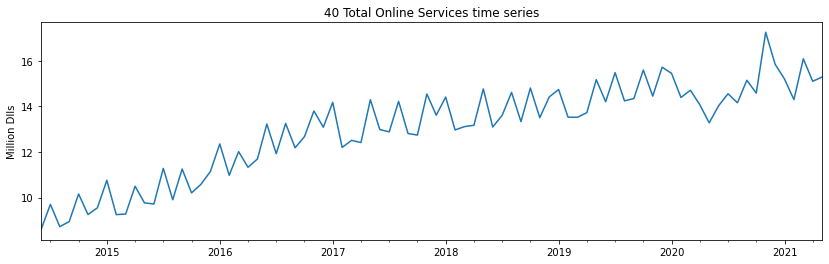

50 Other Managment Solutions


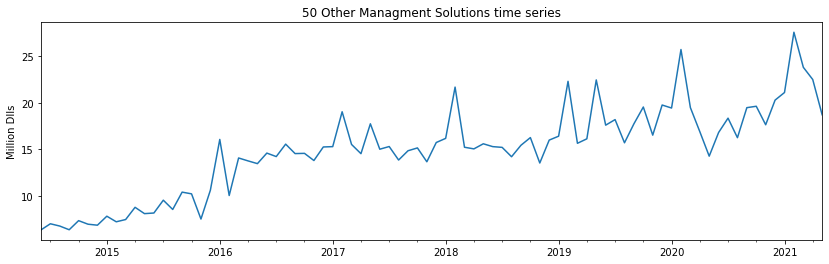

60 Total PEO


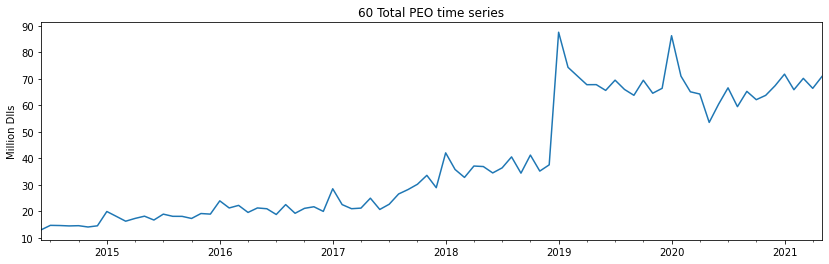

70 Total Insurance Services


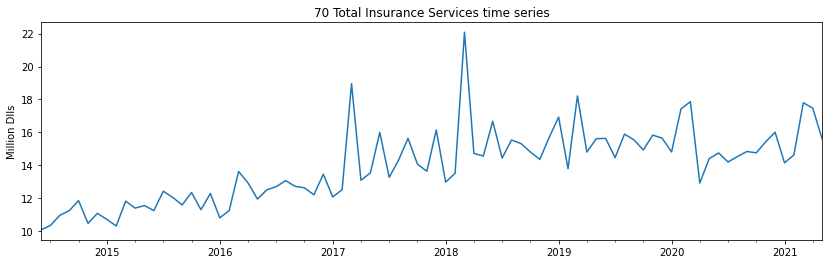

80 Interest on Funds Held for Clients


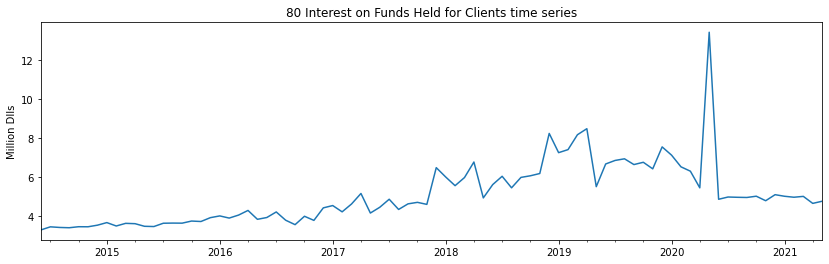

In [15]:
for c in df_month.columns:
    print(c)
    fig, ax = plt.subplots(figsize=(14,4))
    (df_month[c]/1000000).plot(title = c + ' time series', xlabel='', ylabel='Million Dlls', ax=ax)
    #sns.lineplot(data=df_month[c])
    plt.show()

In [16]:
total_revenue = df_month.sum(axis=1)

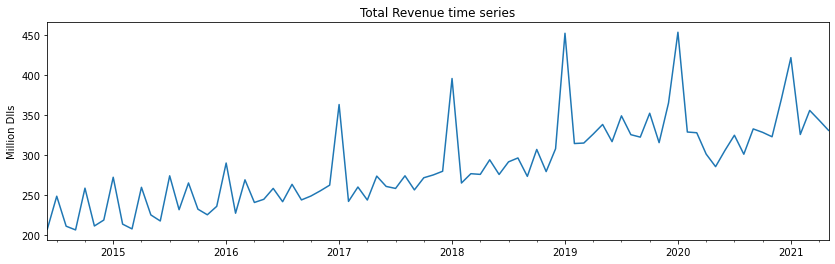

In [17]:
fig, ax = plt.subplots(figsize=(14,4))
(total_revenue/1000000).plot(title = 'Total Revenue time series', xlabel='', ylabel='Million Dlls', ax=ax)
plt.show()

## Participation each item

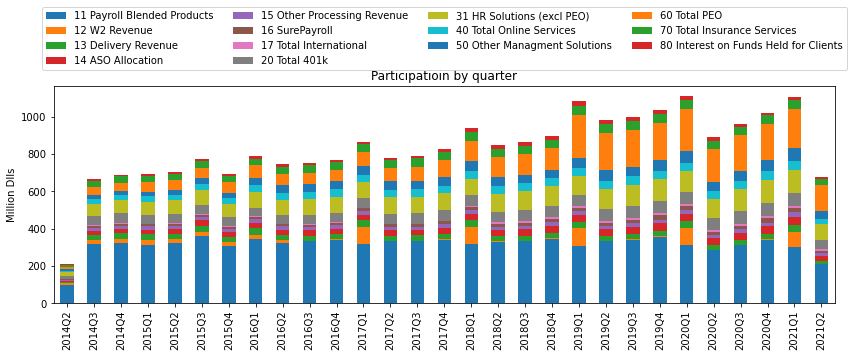

In [18]:
fig, ax = plt.subplots(figsize=(14,4))
(df_month/1000000).resample('Q').sum()\
    .plot.bar(title = 'Participatioin by quarter', xlabel='', ylabel='Million Dlls', stacked=True, ax=ax, legend=False)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=4)
plt.show()

In [19]:
rev_part_y = ((df_month).resample('Y').sum().divide(total_revenue.resample('Y').sum(), axis=0)*100).round(2)

Participation percentage by year

In [20]:
rev_part_y

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services,80 Interest on Funds Held for Clients
Calendar Date,,,,,,,,,,,,,,
2014,47.14,3.45,4.08,3.52,2.41,1.50,0.37,7.39,10.16,4.15,3.05,6.38,4.86,1.54
2015,45.35,3.36,4.19,3.59,2.45,1.55,0.31,6.84,10.44,4.32,3.65,7.57,4.86,1.53
2016,43.81,1.42,4.01,3.72,2.43,1.66,0.33,6.50,10.91,4.87,5.58,8.28,4.92,1.57
2017,40.57,3.01,3.78,3.64,2.28,1.82,0.34,6.68,10.77,4.89,5.70,9.46,5.32,1.75
2018,37.34,2.88,3.47,3.78,2.14,1.79,0.93,6.74,11.07,4.68,5.36,12.54,5.22,2.06
2019,32.57,2.39,2.98,3.71,1.97,1.76,1.06,6.18,10.75,4.27,5.33,20.37,4.58,2.07
2020,31.40,2.40,2.84,3.97,1.86,2.01,1.16,6.70,11.45,4.45,5.63,19.71,4.57,1.85
2021,28.67,4.59,3.10,4.07,2.07,1.96,1.23,6.65,11.72,4.27,6.40,19.41,4.48,1.38


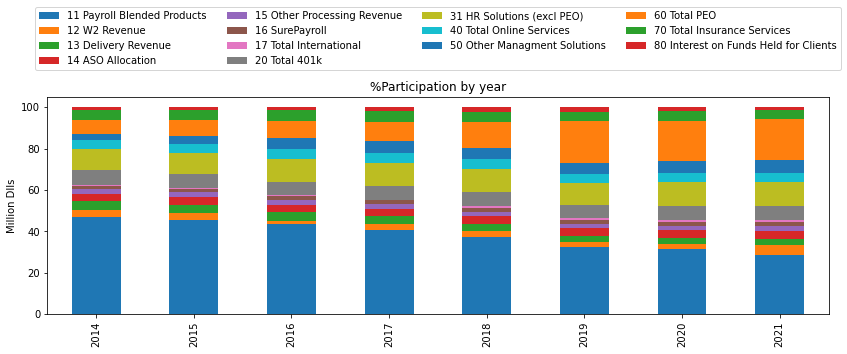

In [21]:
fig, ax = plt.subplots(figsize=(14,4))
rev_part_y.plot.bar(title = '%Participation by year',
                    xlabel='',
                    ylabel='Million Dlls',
                    stacked=True,
                    ax=ax,
                    legend=False)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=4)
plt.show()

## Correlation matrix

In [22]:
rev_cor = df_month.corr()

In [23]:
rev_cor.round(2)

,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services,80 Interest on Funds Held for Clients
11 Payroll Blended Products,1.00,-0.06,0.26,0.27,0.24,0.16,-0.07,-0.05,0.26,0.24,0.03,-0.07,0.07,-0.08
12 W2 Revenue,-0.06,1.00,0.74,0.00,0.58,0.03,0.01,0.02,0.01,0.10,0.02,0.17,-0.08,0.06
13 Delivery Revenue,0.26,0.74,1.00,0.09,0.76,-0.04,-0.02,-0.00,0.08,0.13,0.04,0.11,-0.15,0.02
14 ASO Allocation,0.27,0.00,0.09,1.00,0.33,0.79,0.89,0.87,1.00,0.90,0.80,0.87,0.65,0.50
15 Other Processing Revenue,0.24,0.58,0.76,0.33,1.00,0.22,0.22,0.22,0.33,0.37,0.41,0.38,0.19,0.19
16 SurePayroll,0.16,0.03,-0.04,0.79,0.22,1.00,0.72,0.74,0.79,0.75,0.68,0.70,0.59,0.52
17 Total International,-0.07,0.01,-0.02,0.89,0.22,0.72,1.00,0.90,0.89,0.77,0.71,0.92,0.66,0.63
20 Total 401k,-0.05,0.02,-0.00,0.87,0.22,0.74,0.90,1.00,0.88,0.79,0.74,0.86,0.67,0.58
31 HR Solutions (excl PEO),0.26,0.01,0.08,1.00,0.33,0.79,0.89,0.88,1.00,0.91,0.82,0.87,0.67,0.51
40 Total Online Services,0.24,0.10,0.13,0.90,0.37,0.75,0.77,0.79,0.91,1.00,0.85,0.79,0.70,0.55


<ipython-input-24-e97da9029b9c>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


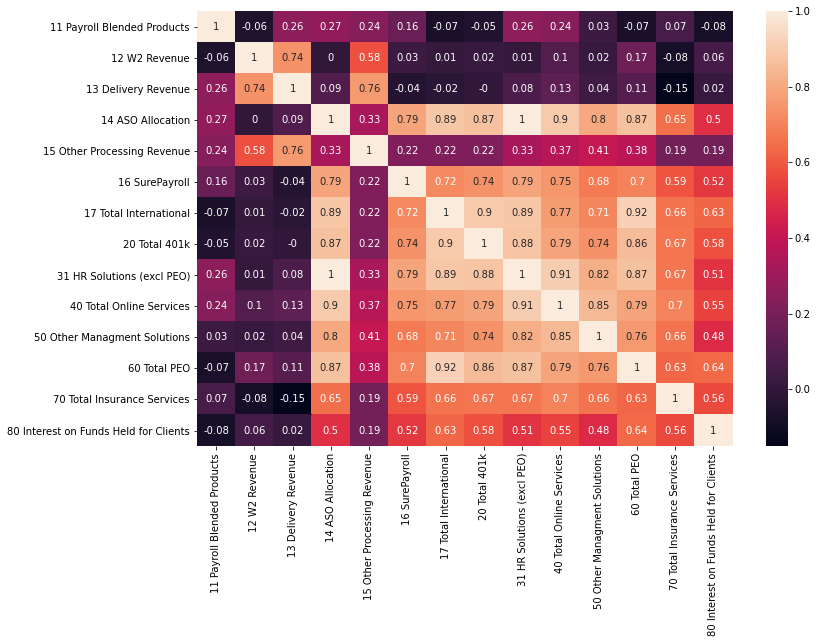

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(rev_cor.round(2), annot=True, ax=ax)
fig.show()

# Monthly Forecast

In [25]:
df_forecast = df[df['Scenario']=='Forecast']

In [26]:
df_forecast

,Scenario,Version,Fiscal Period,11 Payroll Blended Products,12 W2 Revenue,13 Delivery Revenue,14 ASO Allocation,15 Other Processing Revenue,16 SurePayroll,17 Total International,20 Total 401k,31 HR Solutions (excl PEO),40 Total Online Services,50 Other Managment Solutions,60 Total PEO,70 Total Insurance Services,80 Interest on Funds Held for Clients
Calendar Date,,,,,,,,,,,,,,,,,
2021-06,Forecast,2+10,FY2201,114237978.0,146014.28,7829826.55,17035990.52,7463885.63,7156491.88,4724626.92,24192007.0,48479296.0,17751654.0,20761502.0,72023465.0,16255019.0,4839931.0
2021-07,Forecast,2+10,FY2202,113185861.0,129589.02,12439360.29,16379137.69,7623829.39,7317227.02,4343115.44,24136559.0,46831114.0,15854559.0,21904416.0,69583081.0,15856067.0,4853962.0
2021-08,Forecast,2+10,FY2203,118279683.0,174958.27,7682000.12,17303717.40,5970100.45,6946925.22,4290982.72,24568954.0,49270518.0,15563271.0,17777334.0,73077704.0,15185067.0,4648749.0
2021-09,Forecast,2+10,FY2204,113299415.0,228960.00,7149703.22,16962579.43,6435361.37,7143051.58,4629587.00,26121057.0,48319641.0,16818757.0,20170183.0,72497089.0,16507773.0,4637734.0
2021-10,Forecast,2+10,FY2205,105301457.0,183538.79,11224091.41,15652940.90,6924622.68,7401163.00,4482787.87,24429351.0,44798802.0,15856089.0,19750280.0,67456349.0,15930624.0,4686972.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01,Forecast,8+4,FY2208,103869768.0,81839910.32,22435519.84,17242037.23,22172231.60,7943756.66,5022326.69,25826261.0,49289702.0,17506095.0,23202372.0,96241778.0,15110214.0,4865483.0
2022-02,Forecast,8+4,FY2209,103360524.0,87300.99,6683673.54,16746239.66,15262912.02,7782924.02,4508991.80,24740442.0,47754765.0,16548145.0,29695313.0,76514228.0,15595209.0,4676956.0
2022-03,Forecast,8+4,FY2210,116712202.0,-43017.37,7556913.86,19830263.01,13878378.94,7739255.89,4532101.45,25937318.0,55976261.0,18121060.0,23337327.0,81276011.0,18806565.0,4725496.0


In [27]:
I = df_forecast['Version'].unique()
J = df_forecast.select_dtypes(include=np.number).columns

In [29]:
df_forecast[df_forecast['Version']=='2+10']['11 Payroll Blended Products']

Calendar Date
2021-06    114237978.0
2021-07    113185861.0
2021-08    118279683.0
2021-09    113299415.0
2021-10    105301457.0
2021-11    114151474.0
2021-12    119951284.0
2022-01    103631639.0
2022-02     98682935.0
2022-03    111407405.0
2022-04     96772326.0
2022-05    109121211.0
Freq: M, Name: 11 Payroll Blended Products, dtype: float64

11 Payroll Blended Products


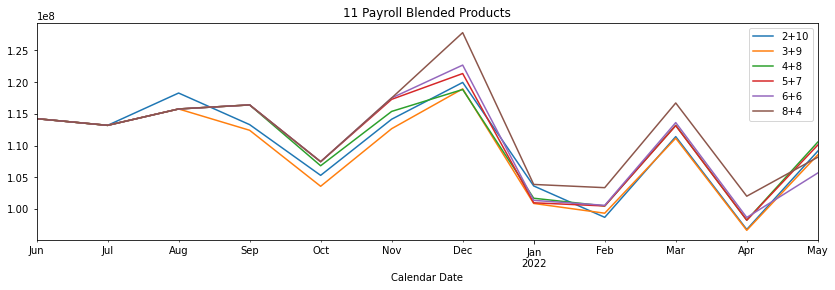

12 W2 Revenue


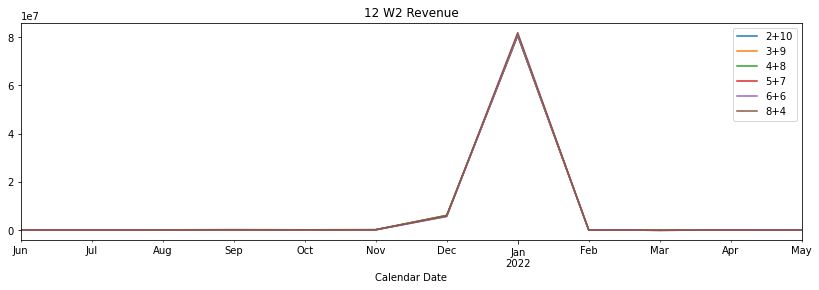

13 Delivery Revenue


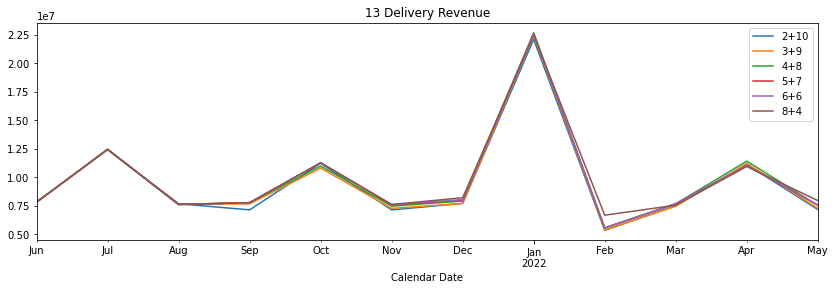

14 ASO Allocation


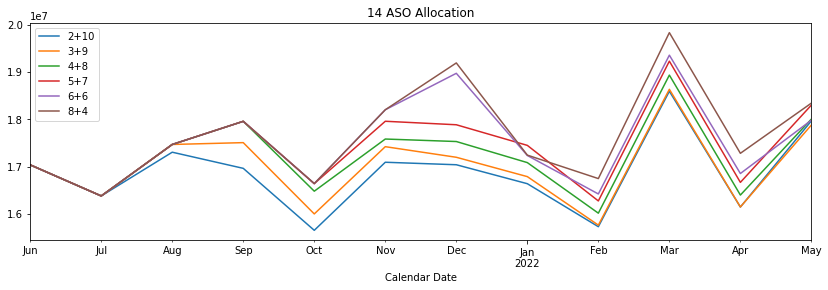

15 Other Processing Revenue


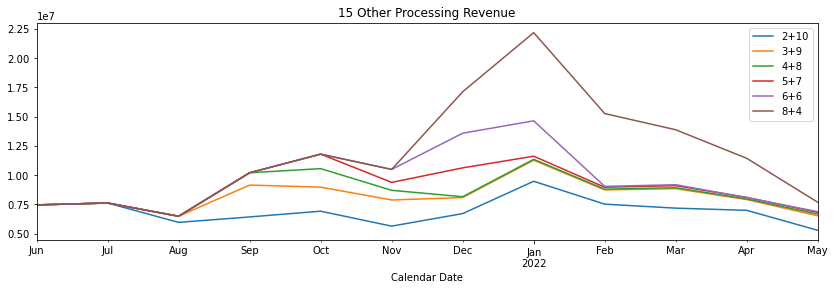

16 SurePayroll


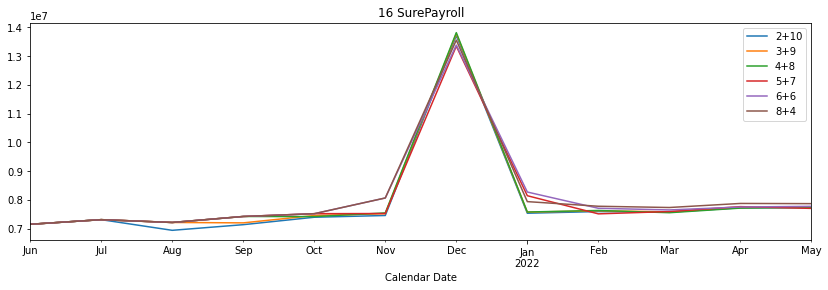

17 Total International


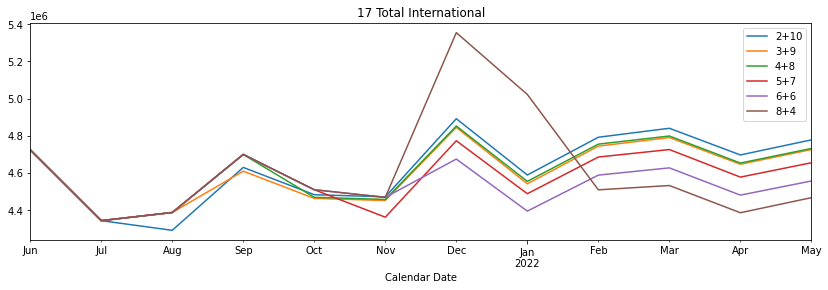

20 Total 401k


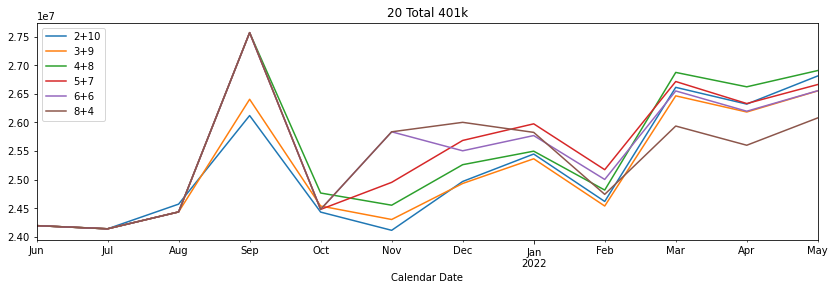

31 HR Solutions (excl PEO)


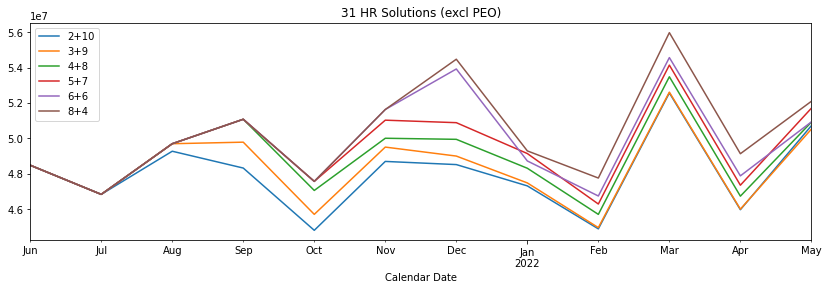

40 Total Online Services


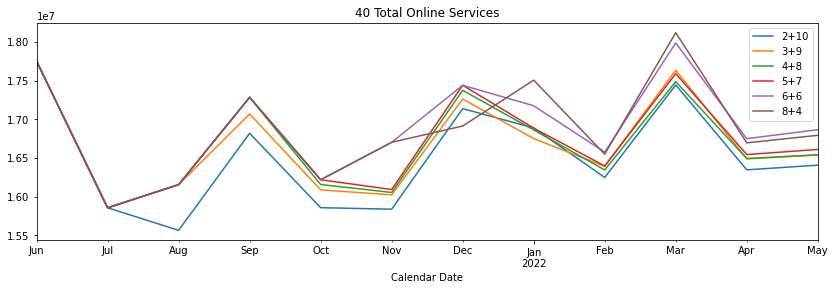

50 Other Managment Solutions


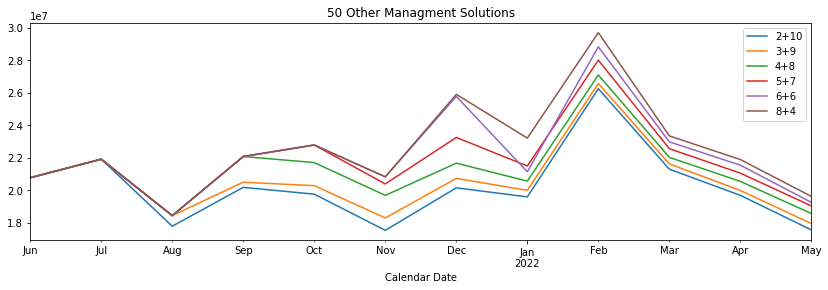

60 Total PEO


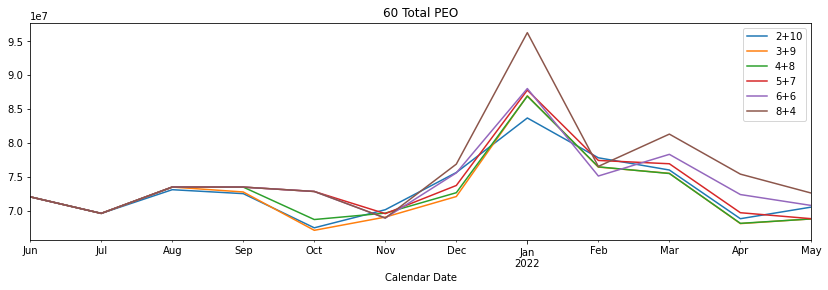

70 Total Insurance Services


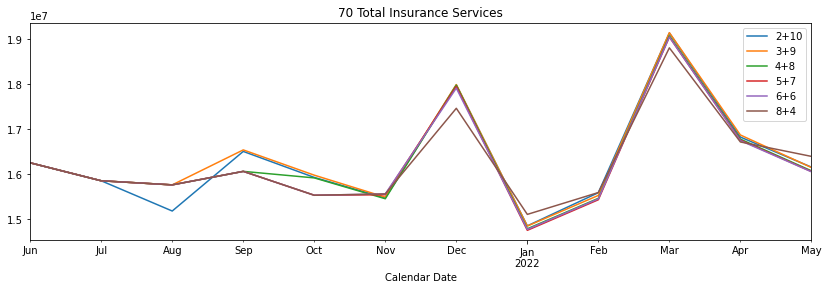

80 Interest on Funds Held for Clients


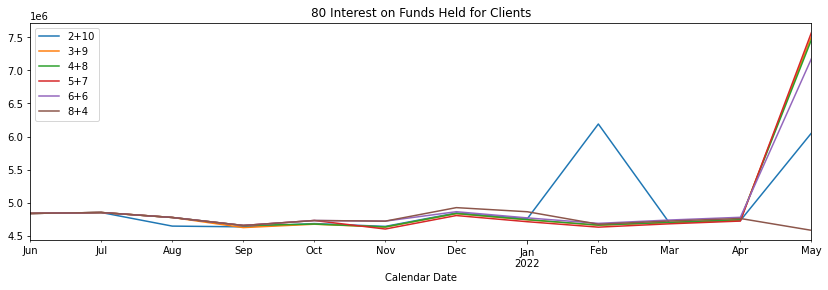

In [30]:
for j in J:
    print(j)
    fig, ax = plt.subplots(figsize=(14,4))
    for i in I:
        df_forecast[df_forecast['Version']==i][j].plot(label=i, ax=ax)
    plt.legend()
    plt.title(j)
    plt.show()

# External Data

## Unemployment rate

In [17]:
# Start client
container_name = "external-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

In [18]:
# Download file
file = 'unemployment_rate.parquet'
stream_downloader = container_client.download_blob(file)
stream = BytesIO()
stream_downloader.readinto(stream)

3475

In [19]:
df_ur = pd.read_parquet(stream, engine='pyarrow')

In [20]:
df_ur

,date,latest,value
0,20220201,true,3.8
1,20220101,None,4.0
2,20211201,None,3.9
3,20211101,None,4.2
4,20211001,None,4.6
...,...,...,...
81,20150501,None,5.6
82,20150401,None,5.4
83,20150301,None,5.4
84,20150201,None,5.5


In [34]:
df_ur['date'] = pd.to_datetime(df_ur['year'] + df_ur['periodName'], format="%Y%B").dt.to_period('M')
df_ur = df_ur.set_index('date')

In [35]:
df_full = pd.concat([df_month,df_ur.value], axis=1).rename(columns={'value': 'unemployment_rate'})

11 Payroll Blended Products


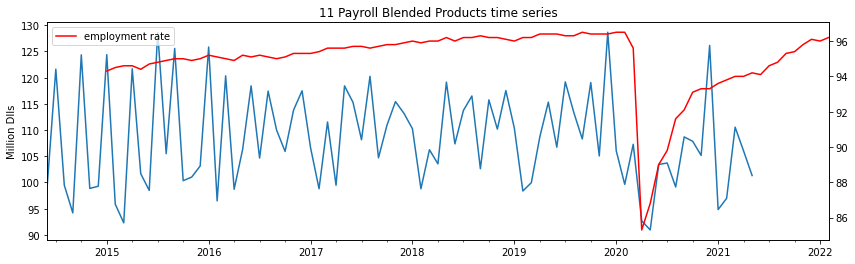

12 W2 Revenue


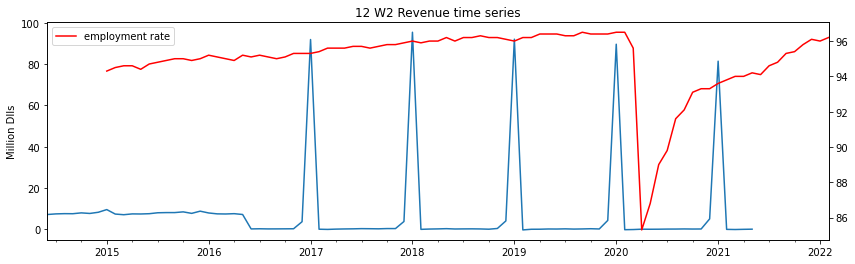

13 Delivery Revenue


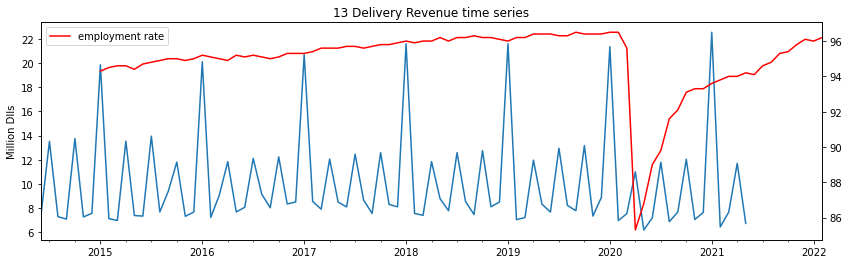

14 ASO Allocation


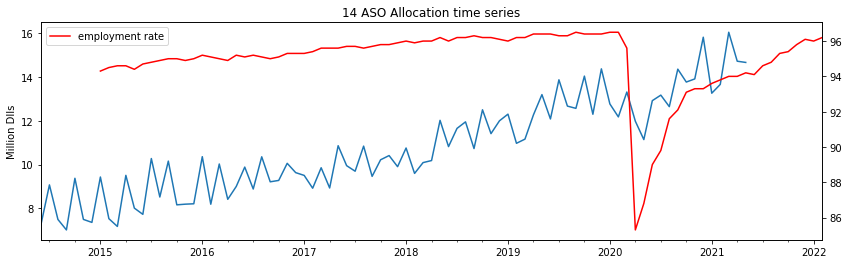

15 Other Processing Revenue


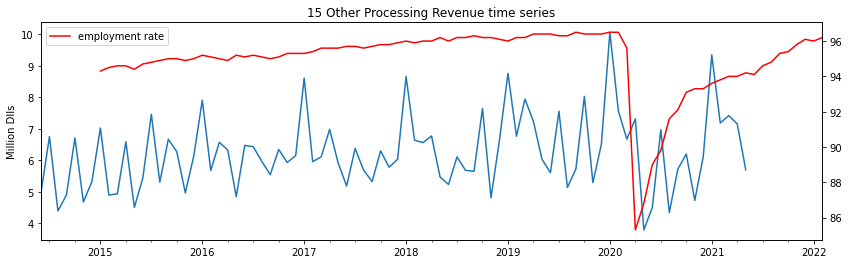

16 SurePayroll


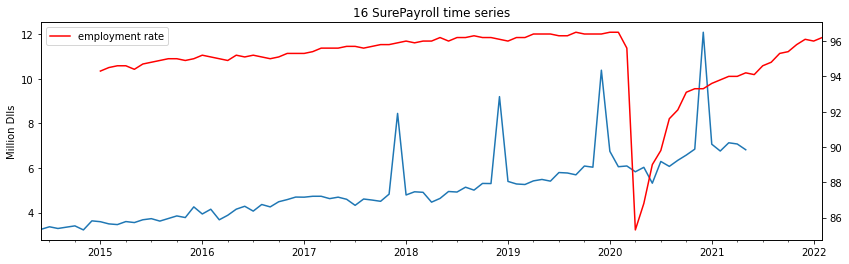

17 Total International


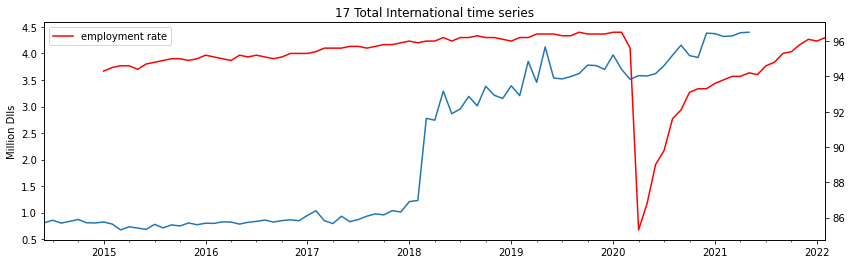

20 Total 401k


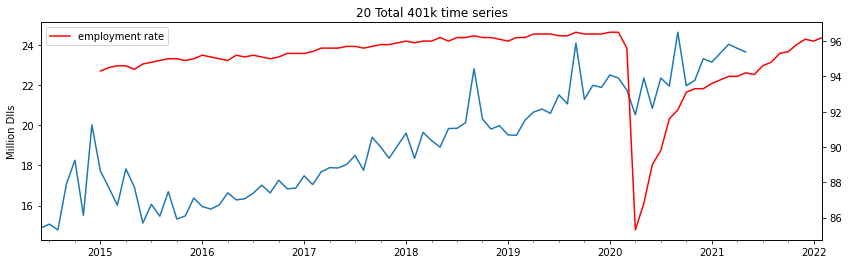

31 HR Solutions (excl PEO)


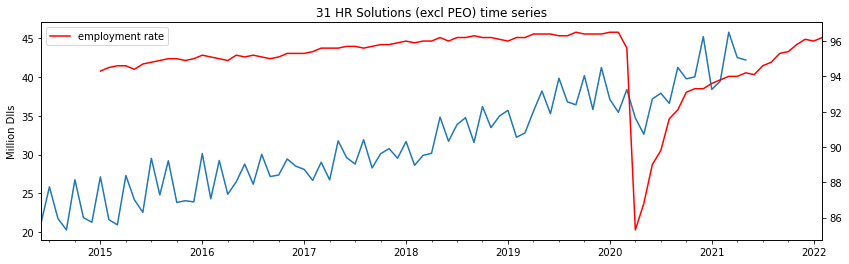

40 Total Online Services


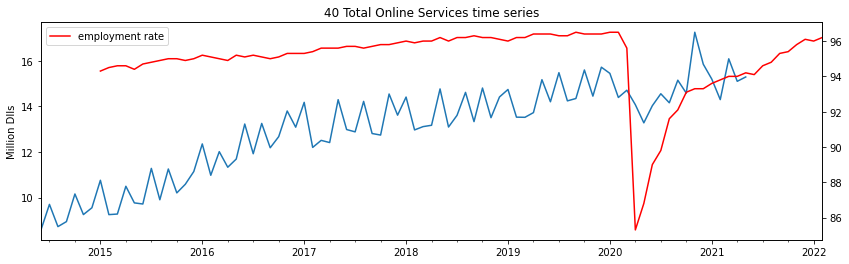

50 Other Managment Solutions


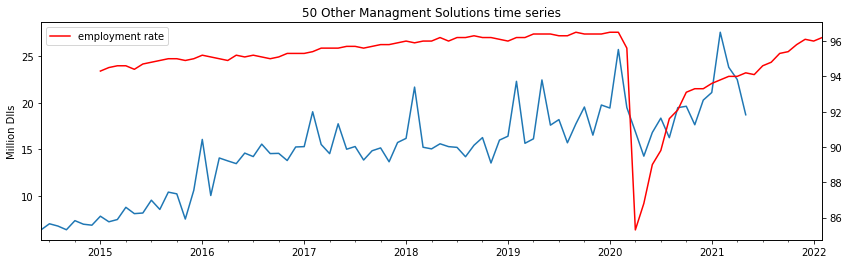

60 Total PEO


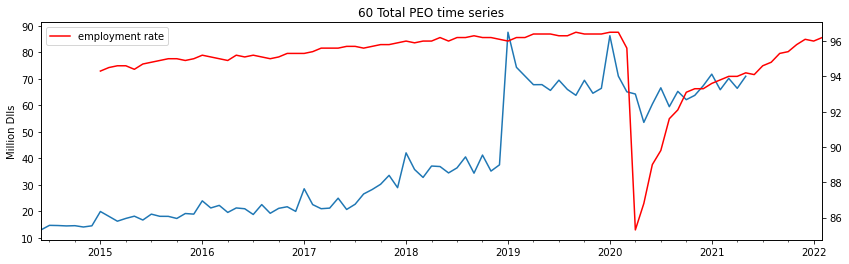

70 Total Insurance Services


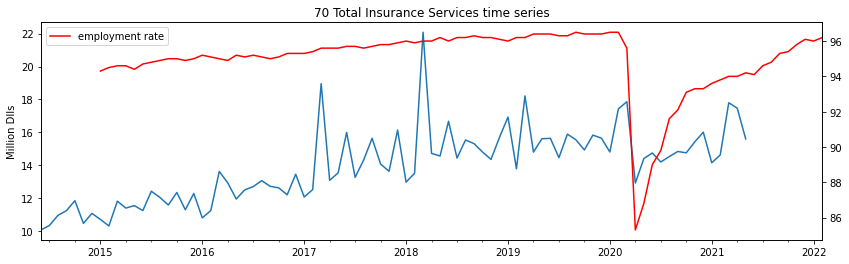

80 Interest on Funds Held for Clients


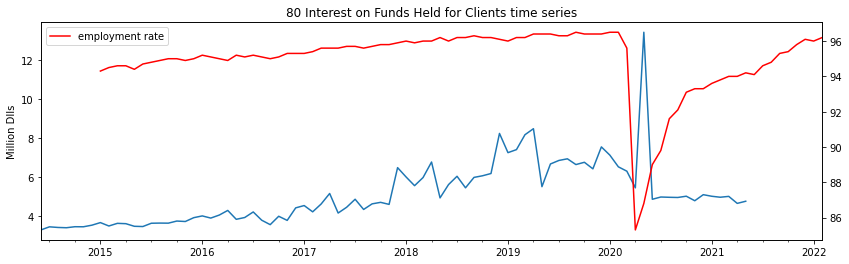

In [36]:
for c in df_month.columns:
    print(c)
    fig, ax = plt.subplots(figsize=(14,4))
    ax2 = ax.twinx()
    (df_full[c]/1000000).plot(title = c + ' time series', xlabel='', ylabel='Million Dlls', label=c, ax=ax)
    (100-df_full['unemployment_rate']).plot(color='red', label='employment rate', ax=ax2)
    #sns.lineplot(data=df_month[c])
    plt.legend()
    plt.show()

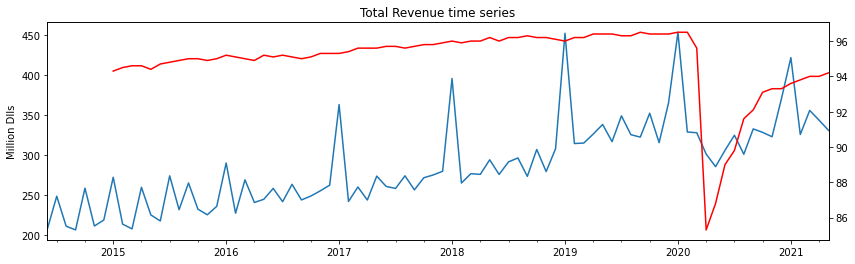

In [37]:
fig, ax = plt.subplots(figsize=(14,4))
ax2 = ax.twinx()
(100-df_full['unemployment_rate']).plot(color='red', label='employment rate', ax=ax2)
(total_revenue/1000000).plot(title = 'Total Revenue time series', xlabel='', ylabel='Million Dlls', ax=ax)
plt.show()

<ipython-input-38-0be50950a9e9>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


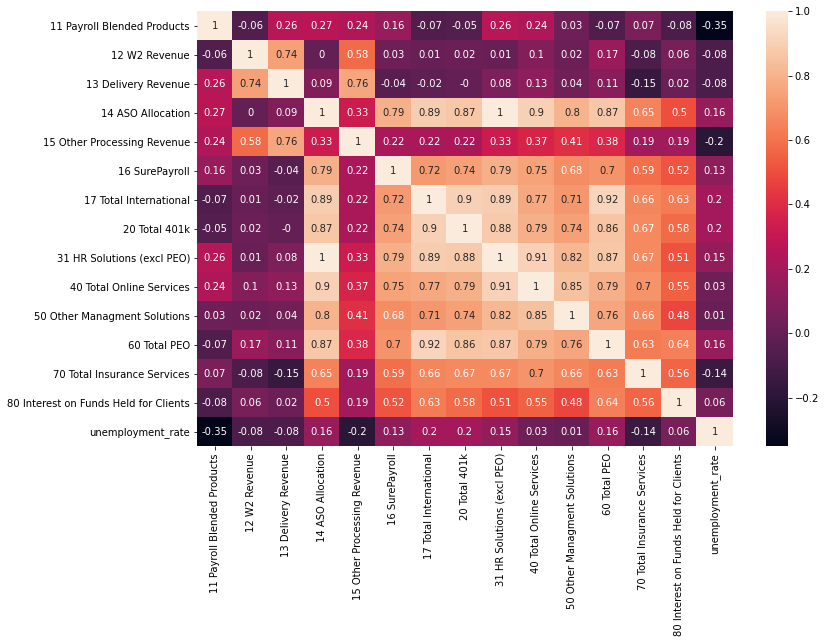

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_full.corr().round(2), annot=True, ax=ax)
fig.show()